In [1]:
import os
import sys 
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
import numpy as np
import json
import sys
import torch
import torch.nn
import torch.optim as optim
from torchvision import transforms, models

import StyleNet
import utils
import clip
import torch.nn.functional as F
from template import imagenet_templates

from PIL import Image 
import PIL 
from torchvision import utils as vutils
import argparse
from torchvision.transforms.functional import adjust_contrast

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VGG = models.vgg19(pretrained=True).features
VGG.to(device)

for parameter in VGG.parameters():
    parameter.requires_grad_(False)
    
def img_denormalize(image):
    mean=torch.tensor([0.485, 0.456, 0.406]).to(device)
    std=torch.tensor([0.229, 0.224, 0.225]).to(device)
    mean = mean.view(1,-1,1,1)
    std = std.view(1,-1,1,1)

    image = image*std + mean
    return image


def img_normalize(image):
    mean=torch.tensor([0.485, 0.456, 0.406]).to(device)
    std=torch.tensor([0.229, 0.224, 0.225]).to(device)
    mean = mean.view(1,-1,1,1)
    std = std.view(1,-1,1,1)

    image = (image-mean)/std
    return image


def clip_normalize(image,device):
    image = F.interpolate(image,size=224,mode='bicubic')
    mean=torch.tensor([0.48145466, 0.4578275, 0.40821073]).to(device)
    std=torch.tensor([0.26862954, 0.26130258, 0.27577711]).to(device)
    mean = mean.view(1,-1,1,1)
    std = std.view(1,-1,1,1)

    image = (image-mean)/std
    return image

    
def get_image_prior_losses(inputs_jit):
    diff1 = inputs_jit[:, :, :, :-1] - inputs_jit[:, :, :, 1:]
    diff2 = inputs_jit[:, :, :-1, :] - inputs_jit[:, :, 1:, :]
    diff3 = inputs_jit[:, :, 1:, :-1] - inputs_jit[:, :, :-1, 1:]
    diff4 = inputs_jit[:, :, :-1, :-1] - inputs_jit[:, :, 1:, 1:]

    loss_var_l2 = torch.norm(diff1) + torch.norm(diff2) + torch.norm(diff3) + torch.norm(diff4)
    
    return loss_var_l2

/disks/1/silky/miniconda3/envs/ldm/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/disks/1/silky/miniconda3/envs/ldm/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
from argparse import Namespace

def compose_text_with_templates(text: str, templates=imagenet_templates) -> list:
    return [template.format(text) for template in templates]

def get_bbox_from_seg(seg_mask):
    ones = torch.where(seg_mask == 1.)
    left, right, top, bottom = max(0, torch.min(ones[3]).item()), torch.max(ones[3]).item(), max(0, torch.min(ones[2]).item()), torch.max(ones[2]).item()
    return left, top, right, bottom

def get_crop_coordinates(pil_t, seg_mask, patch_size):
    left, top, right, bottom = get_bbox_from_seg(seg_mask)

    left_patch, top_patch = None, None
    right_limit = max(right-patch_size+1, 0)
    if right_limit < left:
        left_patch = np.random.randint(right_limit, left)

    bottom_limit = max(bottom-patch_size+1, 0)
    if bottom_limit < top:
        top_patch = np.random.randint(bottom_limit, top)

    if left_patch is None:
        left_patch = np.random.randint(left, right_limit+1)  # adding 1 to bypass [low, high) 

    if top_patch is None:
        top_patch = np.random.randint(top, bottom_limit+1)
        
    return top_patch, left_patch, patch_size, patch_size


# imports and pre-load the LLaVA and SAM models here.
import sys
sys.path.append('../')
from text_to_seg import pre_load_models, get_segmentation_from_user_prompt

tokenizer, model, image_processor, predictor = pre_load_models()


You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.


Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

/disks/1/silky/miniconda3/envs/ldm/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/disks/1/silky/miniconda3/envs/ldm/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:394: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `None` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Llava output => The bounding box coordinates for the chair on the left of the sofa are: [0.000,0.556,0.177,0.919]. The corresponding style to be applied is "Starry Night by Van Gogh".
running LEAST with style => starry night by van gogh


/disks/1/silky/miniconda3/envs/ldm/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


After 0 iters:
Total loss:  14522.6484375
Content loss:  4442.004203796387
patch loss:  9545.8984375
dir loss:  536.62109375
TV loss:  0.1446242481470108


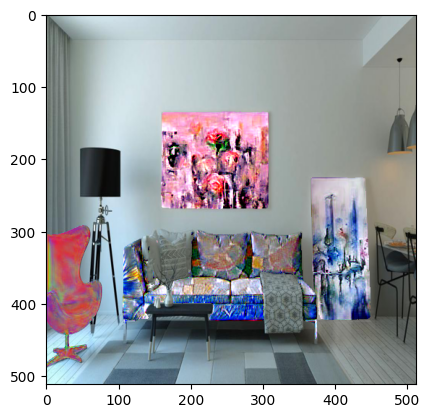

After 50 iters:
Total loss:  11518.9375
Content loss:  3579.796314239502
patch loss:  7539.0625
dir loss:  398.92578125
TV loss:  0.1401967853307724


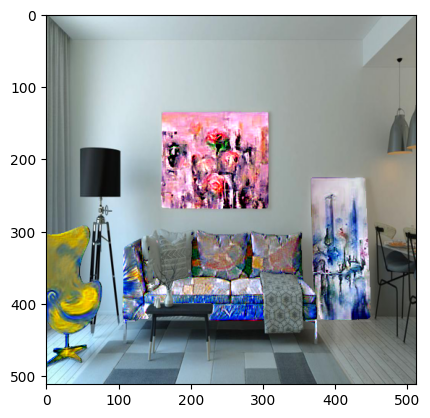

After 100 iters:
Total loss:  10106.4560546875
Content loss:  3171.5606689453125
patch loss:  6572.265625
dir loss:  362.79296875
TV loss:  0.14553198218345642


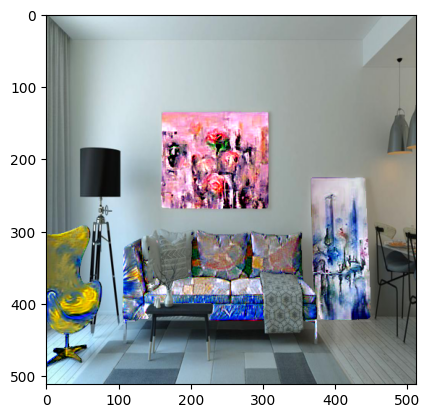

After 150 iters:
Total loss:  6791.9462890625
Content loss:  2949.795627593994
patch loss:  3491.2109375
dir loss:  350.09765625
TV loss:  0.15039466321468353


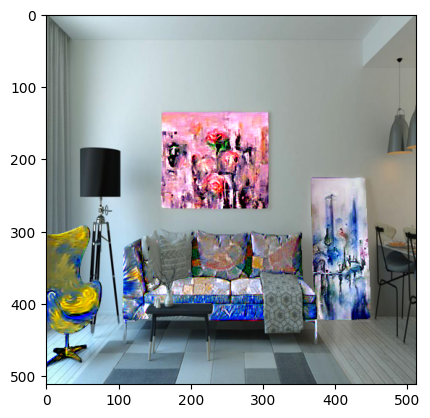

After 200 iters:
Total loss:  6066.54296875
Content loss:  2801.139450073242
patch loss:  2919.921875
dir loss:  345.21484375
TV loss:  0.1535436511039734


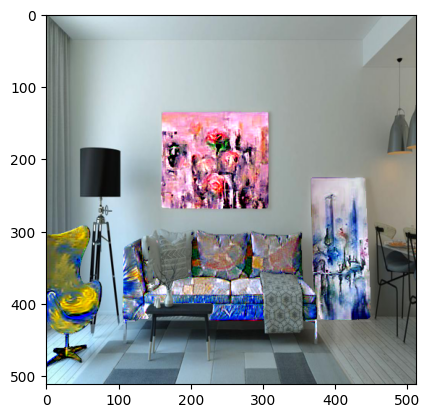

In [5]:
# set path to image and corresponding style description here..
image_path = "../CLIPstyler/compositional_outputs/paper_results/interior1_mosaic_roses_watercolor.png"
text = f"apply Starry Night by Van Gogh style to the chair on the left of sofa in the image"

seg_mask, style_text = get_segmentation_from_user_prompt(image_path, text, tokenizer, model, image_processor, predictor)
print("running LEAST with style =>", style_text)

clip_model, preprocess = clip.load('ViT-B/32', device, jit=False)


training_iterations = 200
training_args = {
    "lambda_tv": 2e-3,   
    "lambda_patch": 10000,
    "lambda_dir": 500,
    "lambda_c": 150,
    "crop_size": 100,
    "num_crops": 64,
    "img_height": 512,
    "img_width": 512,
    "max_step": training_iterations,
    "lr": 5e-4,
    "thresh": 0.7,
    "content_path": image_path,
    "text": style_text
}

args = Namespace(**training_args)


content_path = args.content_path
content_image = utils.load_image(content_path, args.img_height)
content_image = content_image.to(device)

seg_mask = Image.fromarray((seg_mask*255.).astype(np.uint8))
segmask_image = utils.load_seg_mask2(seg_mask, img_height=args.img_height, img_width=args.img_width)
segmask_image = segmask_image.to(device)

bbox_left, bbox_top, bbox_right, bbox_bottom = get_bbox_from_seg(segmask_image)

content_features = utils.get_features(img_normalize(content_image), VGG)
masked_content_features = utils.get_features(img_normalize(content_image*(segmask_image)), VGG)

cropped_content_image = transforms.functional.resized_crop(content_image, bbox_top, bbox_left, bbox_bottom-bbox_top, bbox_right-bbox_left, (args.img_height, args.img_width))
cropped_content_features = utils.get_features(img_normalize(cropped_content_image), VGG)


style_net = StyleNet.UNet(input_channel=3)
style_net.to(device)
# style_net.load_state_dict(torch.load("/path/to/model.pth", map_location='cpu'))    # same initialization for all experiments.

style_weights = {'conv1_1': 0.1,
                 'conv2_1': 0.2,
                 'conv3_1': 0.4,
                 'conv4_1': 0.8,
                 'conv5_1': 1.6}

content_weight = args.lambda_c

show_every = 100
optimizer = optim.Adam(style_net.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
steps = args.max_step

content_loss_epoch = []
style_loss_epoch = []
total_loss_epoch = []

output_image = content_image

m_cont = torch.mean(content_image,dim=(2,3), keepdim=False).squeeze(0)
m_cont = [m_cont[0].item(), m_cont[1].item(), m_cont[2].item()]

cropper = transforms.Compose([
    transforms.RandomCrop(args.crop_size)
])
augment = transforms.Compose([
    transforms.RandomPerspective(fill=0, p=1, distortion_scale=0.5),
    transforms.Resize(224)
])

prompt = args.text
source = "a Photo"

with torch.no_grad():
    template_text = compose_text_with_templates(prompt, imagenet_templates)
    tokens = clip.tokenize(template_text).to(device)
    text_features = clip_model.encode_text(tokens).detach()
    text_features = text_features.mean(axis=0, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    template_source = compose_text_with_templates(source, imagenet_templates)
    tokens_source = clip.tokenize(template_source).to(device)
    text_source = clip_model.encode_text(tokens_source).detach()
    text_source = text_source.mean(axis=0, keepdim=True)
    text_source /= text_source.norm(dim=-1, keepdim=True)

    source_features = clip_model.encode_image(clip_normalize(content_image, device))
    source_features /= (source_features.clone().norm(dim=-1, keepdim=True))

    masked_source_features = clip_model.encode_image(clip_normalize(content_image*segmask_image,device))
    masked_source_features /= (masked_source_features.clone().norm(dim=-1, keepdim=True))

    cropped_source_features = clip_model.encode_image(clip_normalize(cropped_content_image,device))
    cropped_source_features /= (cropped_source_features.clone().norm(dim=-1, keepdim=True))

num_crops = args.num_crops

for epoch in range(0, steps+1):
    scheduler.step()

    target = style_net(content_image, use_sigmoid=True).to(device)
    target.requires_grad_(True) 

    target_cropped = transforms.functional.resized_crop(target, bbox_top, bbox_left, bbox_bottom-bbox_top, bbox_right-bbox_left, (args.img_height, args.img_width))

    target_features = utils.get_features(img_normalize(target), VGG)
    masked_target_features = utils.get_features(img_normalize(target*(segmask_image)), VGG)
    cropped_target_features = utils.get_features(img_normalize(target_cropped), VGG)

    content_loss = 0
    content_loss += torch.mean((cropped_target_features['conv4_2'] - cropped_content_features['conv4_2']) ** 2)
    content_loss += torch.mean((cropped_target_features['conv5_2'] - cropped_content_features['conv5_2']) ** 2)

    loss_patch = 0 
    img_proc = []

    for n in range(num_crops):
        top, left, h, w = get_crop_coordinates(target, segmask_image, args.crop_size)
        target_crop = transforms.functional.crop(target, top, left, h, w)
        seg_crop = transforms.functional.crop(segmask_image, top, left, h, w)

        target_crop = augment(target_crop)
        img_proc.append(target_crop)

    img_proc = torch.cat(img_proc, dim=0)
    img_aug = img_proc

    image_features = clip_model.encode_image(clip_normalize(img_aug, device))
    image_features /= (image_features.clone().norm(dim=-1, keepdim=True))

    img_direction = (image_features - source_features)
    img_direction /= img_direction.clone().norm(dim=-1, keepdim=True)

    text_direction = (text_features - text_source).repeat(image_features.size(0),1)
    text_direction /= text_direction.norm(dim=-1, keepdim=True)
    loss_temp = (1. - torch.cosine_similarity(img_direction, text_direction, dim=1))
    loss_temp[loss_temp < args.thresh] = 0
    loss_patch += loss_temp.mean()

    masked_glob_features = clip_model.encode_image(clip_normalize(target*segmask_image, device))
    masked_glob_features /= (masked_glob_features.clone().norm(dim=-1, keepdim=True))

    cropped_glob_features = clip_model.encode_image(clip_normalize(target_cropped, device))
    cropped_glob_features /= (cropped_glob_features.clone().norm(dim=-1, keepdim=True))

    glob_direction = (masked_glob_features - masked_source_features)
    glob_direction /= glob_direction.clone().norm(dim=-1, keepdim=True)

    loss_glob = (1 - torch.cosine_similarity(glob_direction, text_direction, dim=1)).mean()

    reg_tv = args.lambda_tv * get_image_prior_losses(target*segmask_image)

    total_loss = args.lambda_patch*loss_patch + content_weight*content_loss + reg_tv + args.lambda_dir*loss_glob
    total_loss_epoch.append(total_loss)
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print("After %d iters:" % epoch)
        print('Total loss: ', total_loss.item())
        print('Content loss: ', content_loss.item() * args.lambda_c)
        print('patch loss: ', loss_patch.item() * args.lambda_patch)
        print('dir loss: ', loss_glob.item() * args.lambda_dir)
        print('TV loss: ', reg_tv.item())

        
    if epoch % 50 == 0:
        output_image = target.clone()
        output_image = torch.clamp(output_image,0,1)
        output_image = adjust_contrast(output_image,1.5)
        output_converted = utils.im_convert2(output_image)
        
        src = np.array(Image.open(image_path).resize((args.img_width, args.img_height), Image.BICUBIC))
        sty1 = (output_converted*255.).astype(np.uint8)
        seg1 = np.array(seg_mask.resize((args.img_width, args.img_height), Image.NEAREST).convert("RGB"))/255.

        styled = (sty1 * seg1 + (1.-seg1) * src).astype(np.uint8)
        plt.imshow(styled)
        plt.show()
        

        

In [ ]:
# from torchmetrics.multimodal.clip_score import CLIPScore
# metric = CLIPScore(model_name_or_path="openai/clip-vit-base-patch16").to(device)

# def patchCLIPscore(images, seg_mask, text, num_crops=64, crop_size=224):
#     scores = []
    
#     left, top, right, bottom = get_bbox_from_seg(seg_mask)
#     for idx,img in enumerate(images):
#         print('calculating CLIP score..', torch.min(img), torch.max(img))
#         cropped = transforms.functional.crop(img, top, left, bottom-top, right-left)
#         score = metric(cropped, text)
#         scores.append(score.item())

#     return scores